In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import scipy.integrate as integrate

###new
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI COLAB/PROYECTO/dataset/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


#**1. Primera Entrega**

In [ ]:
#clean the df
df = df.dropna(subset=["age"])
df = df.query("sex != 'unknown'")

Primeras filas del dataset:
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 9948 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     9948 non-null   object 
 1   image_id      9948 non-null   object 
 2   dx            9948 non-null   object 
 3   dx_type       9948 non-null   object 
 4   age           9948 non-null   float64
 5   sex           9948 non-null   object 
 6   localization  9948 non-null   object 
dtypes: float64(1), object(6)
memory usage: 621.8+ KB
Estadísticas descriptivas:

 dx
nv       6650
mel      1111
bkl      1089
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

 Benign:

 benign keratosis-like lesions (bkl),
 melanocytic nevi (nv),
 dermatofibroma (df),
 vascular lesions (vasc).

 Malign:

 melanoma (mel),
 basal cell carcinoma (bcc),
 and Actinic keratoses and intraepithelial carcinoma / Bowen's disease

,age
dx,
akiec,66.529052
bcc,66.828794
bkl,64.283747
df,53.043478
mel,60.679568
nv,46.490977
vasc,51.373239


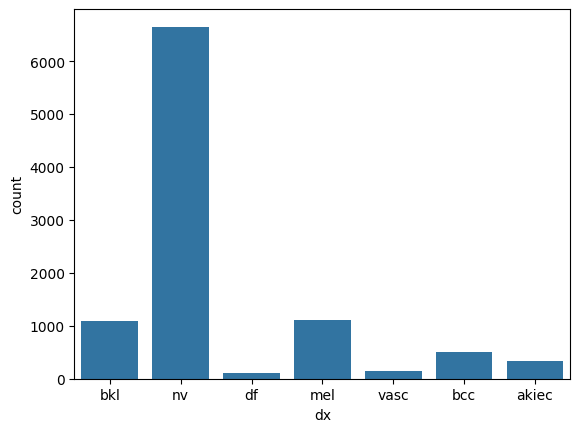

In [ ]:
print("Primeras filas del dataset:")
df.head()

print("Información del dataset:")
df.info()

print("Estadísticas descriptivas:")
df.describe()

sns.countplot(x = "dx", data = df)
print("\n",df["dx"].value_counts())

print("\n Benign:")
print("\n benign keratosis-like lesions (bkl),\n melanocytic nevi (nv),\n dermatofibroma (df),\n vascular lesions (vasc).")
print("\n Malign:")
print("\n melanoma (mel),\n basal cell carcinoma (bcc),\n and Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec).")

df.groupby("dx").mean(numeric_only=True)


In [ ]:
benign = ["bkl", "nv", "df", "vasc"]
malign = ["mel", "bcc", "akiec"]
benign2 = ["bkl", "df", "vasc"]
benign_count = df[df["dx"].isin(benign)]["dx"].count()
malign_count = df[df["dx"].isin(malign)]["dx"].count()
benign_count2 = df[df["dx"].isin(benign2)]["dx"].count()
print('benign:',benign_count)
print('malign:',malign_count)
print('benign without nv (melanocytic nevi):',benign_count2)

benign: 7996
malign: 1952
benign without nv (melanocytic nevi): 1346


<Axes: xlabel='age'>

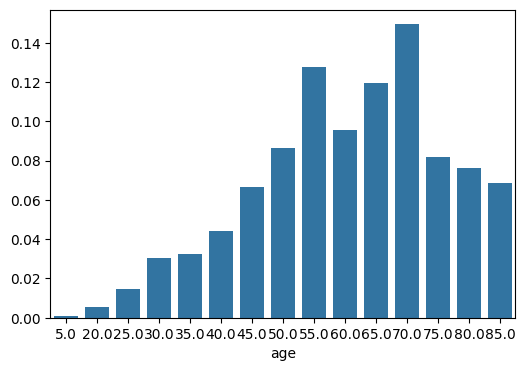

In [ ]:
#barplot of the dataset with ages and melanoma
df_mel = df[df["dx"] == "mel"]["age"].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
sns.barplot(x=df_mel.index, y=df_mel.values)

Correlation of age between men and women with melanoma:


<Axes: xlabel='age', ylabel='Density'>

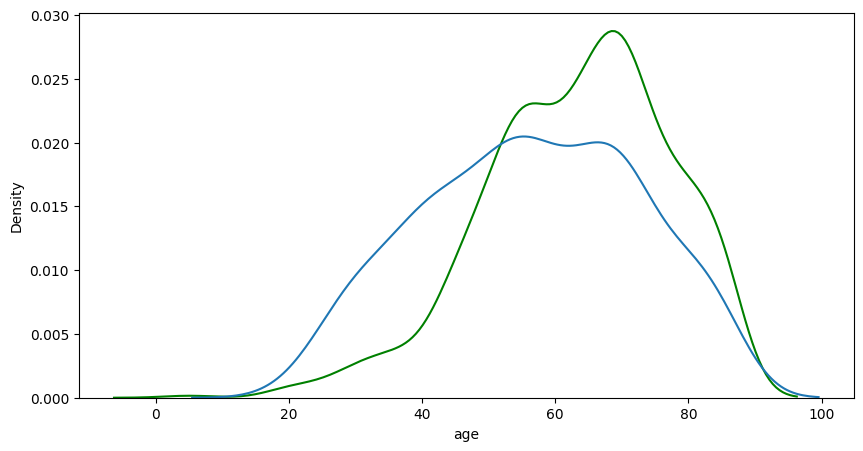

In [ ]:
#differences between male and female in the dataset that have melanoma
df_mel = df[df["dx"] == "mel"]

print("Correlation of age between men and women with melanoma:")
plt.figure(figsize=(10,5))
#plt.subplot(1,4, 1);
sns.kdeplot(df_mel[df_mel["sex"] == "male"]["age"],color="green")
#plt.subplot(1,4, 2);
sns.kdeplot(df_mel[df_mel["sex"] == "female"]["age"])

<bound method Series.count of localization
lower extremity    0.222406
back               0.214286
trunk              0.186015
abdomen            0.128872
upper extremity    0.098195
foot               0.041955
chest              0.029774
unknown            0.023910
face               0.015038
neck               0.012180
hand               0.008271
scalp              0.006767
genital            0.006767
ear                0.004511
acral              0.001053
Name: proportion, dtype: float64>


<Axes: xlabel='localization'>

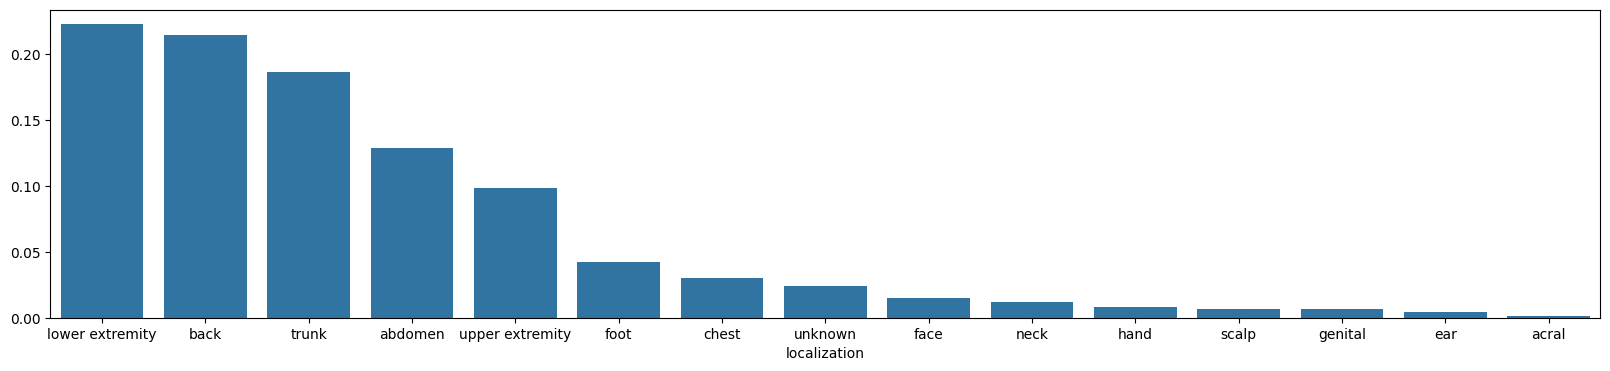

In [ ]:
df_mel = df[df["dx"] == "nv"]["localization"].value_counts(normalize=True)
print(df_mel.count)
plt.figure(figsize=(20, 4))
sns.barplot(x=df_mel.index, y=df_mel.values)

#**2. Segunda Entrega**


In [ ]:
#base directory
base_dir = '/content/drive/MyDrive/AI COLAB/PROYECTO/dataset/'

#dictionary with each type of lesion
lesion_type = {
    'nv': 'Melanocytic nevi',                  #0
    'mel': 'Melanoma',                         #1
    'bkl': 'Benign keratosis-like lesions ',   #2
    'bcc': 'Basal cell carcinoma',             #3
    'akiec': 'Actinic keratoses',              #4
    'vasc': 'Vascular lesions',                #5
    'df': 'Dermatofibroma'                     #6
}

In [ ]:
def load_image_cv2(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (64, 48))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

malignos = ['mel', 'bcc', 'akiec']
df['label'] = df['dx'].apply(lambda x: 'maligno' if x in malignos else 'benigno')

from sklearn.utils import resample

benigno_df = df[df['label'] == 'benigno']
maligno_df = df[df['label'] == 'maligno']
min_size = min(len(benigno_df), len(maligno_df))

benigno_df = resample(benigno_df, replace=False, n_samples=min_size, random_state=42)
maligno_df = resample(maligno_df, replace=False, n_samples=min_size, random_state=42)

df_balanced = pd.concat([benigno_df, maligno_df]).reset_index(drop=True)

imageid_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

df_balanced['path'] = df_balanced['image_id'].map(imageid_path.get)
df_balanced['image'] = df_balanced['path'].map(load_image_cv2)

X = np.stack(df_balanced['image'].values) / 255.0
y = df_balanced['label'].map({'benigno': 0, 'maligno': 1}).values

array([[[170, 145, 167],
        [164, 132, 162],
        [167, 135, 158],
        ...,
        [176, 169, 185],
        [175, 166, 183],
        [171, 157, 174]],

       [[169, 137, 161],
        [164, 135, 155],
        [168, 131, 155],
        ...,
        [179, 169, 182],
        [174, 171, 184],
        [175, 162, 177]],

       [[172, 146, 169],
        [171, 146, 165],
        [167, 135, 156],
        ...,
        [171, 162, 167],
        [179, 170, 180],
        [177, 164, 181]],

       ...,

       [[165, 144, 159],
        [168, 147, 168],
        [165, 148, 164],
        ...,
        [171, 164, 179],
        [171, 164, 180],
        [164, 162, 174]],

       [[165, 145, 166],
        [166, 148, 166],
        [164, 152, 165],
        ...,
        [169, 154, 168],
        [164, 161, 173],
        [166, 157, 171]],

       [[168, 152, 171],
        [165, 151, 169],
        [163, 144, 164],
        ...,
        [173, 160, 177],
        [167, 161, 175],
        [158, 157, 170]]], dtype=uint8)
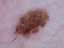

In [ ]:
df_balanced['image'][0]

In [ ]:
df_balanced['label'].value_counts()

,count
label,
benigno,1952
maligno,1952


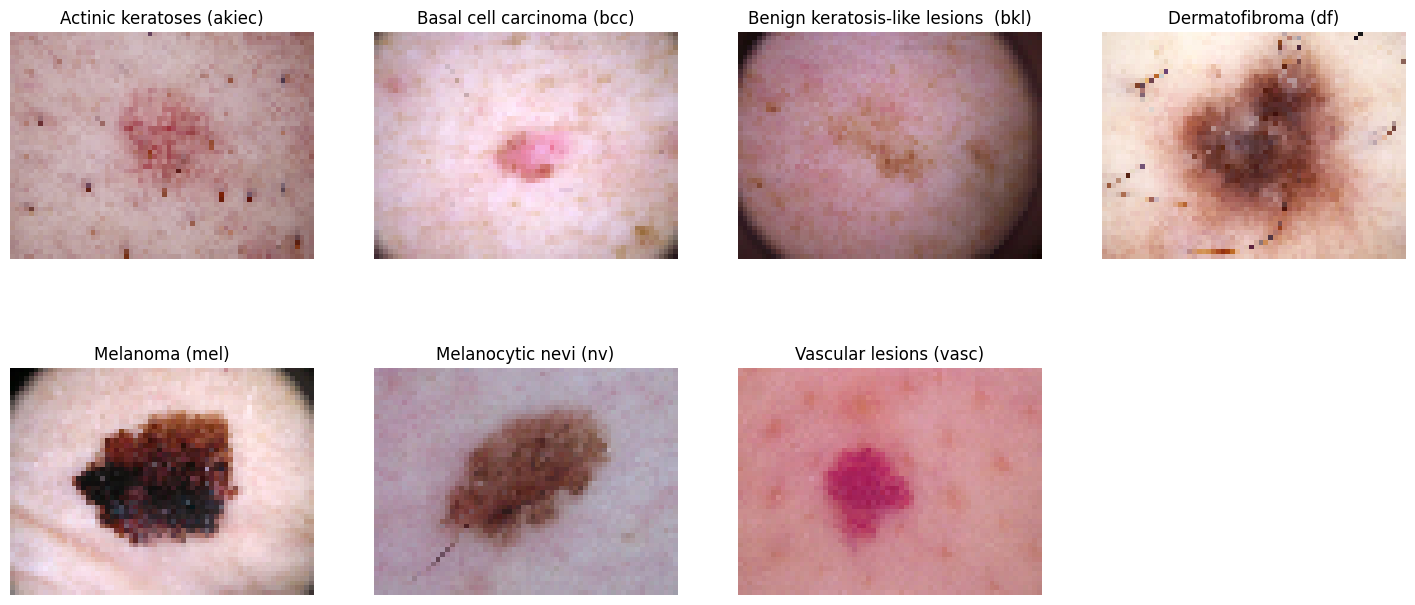

In [ ]:
lesion_type_unic = sorted(lesion_type.keys())

plt.figure(figsize=(18, 8))
for i, tipo in enumerate(lesion_type_unic):
    imagen = df_balanced[df_balanced['dx'] == tipo]['image'].iloc[0]
    plt.subplot(2, 4, i+1)
    plt.imshow(imagen.astype('uint8'))
    plt.title(f"{lesion_type[tipo]} ({tipo})")
    plt.axis('off')

plt.show()

#**3. Tercera Entrega**

In [ ]:
x_train, x_test, y_train_o, y_test_o = train_test_split(X, y, test_size=0.20,random_state=999, stratify=y)
#stratify=y ayuda a la partición a separar entre clases de forma controlada

In [ ]:
#one hot codification
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999, stratify=y_train)
x_train = x_train.reshape(x_train.shape[0], *(48, 64, 3))
x_test = x_test.reshape(x_test.shape[0], *(48, 64, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(48, 64, 3))

In [ ]:
#@title plot model
def plot_model_history(history):
    # Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,785,026 (18.25 MB)

 Trainable params: 4,785,026 (18.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5600 - loss: 0.8245 - val_accuracy: 0.6134 - val_loss: 0.6836
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6320 - loss: 0.6455 - val_accuracy: 0.5719 - val_loss: 0.6308
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6522 - loss: 0.6128 - val_accuracy: 0.6677 - val_loss: 0.6109
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6734 - loss: 0.6002 - val_accuracy: 0.6645 - val_loss: 0.5905
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6706 - loss: 0.5843 - val_accuracy: 0.6677 - val_loss: 0.5838
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6730 - loss: 0.5759 - val_accuracy: 0.6677 - val_loss: 0.5797
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6830 - loss: 0.5653 - val_accuracy: 0.6262 - val_loss: 0.6163
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7024 - loss: 0.5520 - val_accuracy: 0.6837 - v

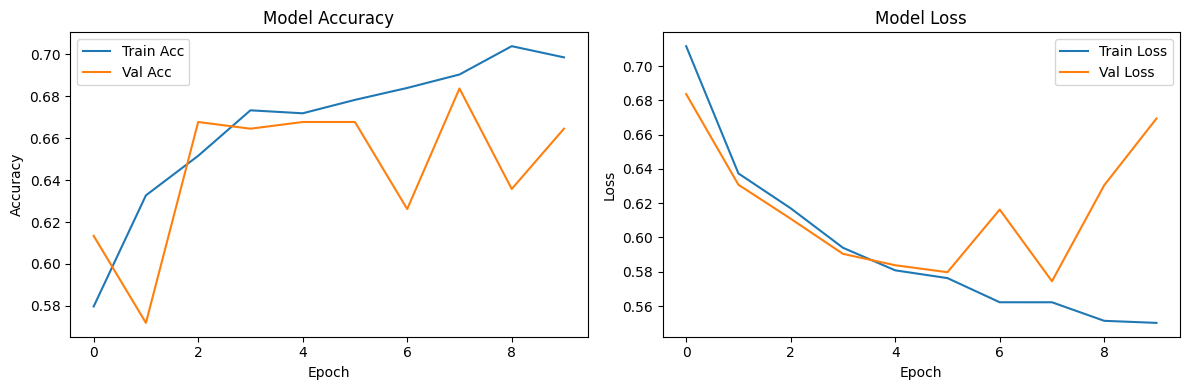

In [ ]:
#@title model ANN relu
model_ann_relu = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48, 64, 3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_ann_relu.summary()

model_ann_relu.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history=model_ann_relu.fit(
    x_train, y_train,
    validation_data=(x_validate, y_validate),
    epochs=10,
    batch_size=32
)

test_loss_ann_relu, test_acc_ann_relu = model_ann_relu.evaluate(x_test, y_test)
print('Test accuracy:', test_acc_ann_relu)

plot_model_history(history)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 56s 584ms/step - accuracy: 0.4808 - loss: 2.1562 - val_accuracy: 0.6422 - val_loss: 0.6620
Epoch 2/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 455ms/step - accuracy: 0.5310 - loss: 0.7451 - val_accuracy: 0.5016 - val_loss: 0.8983
Epoch 3/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 449ms/step - accuracy: 0.5714 - loss: 0.6844 - val_accuracy: 0.6038 - val_loss: 0.9125
Epoch 4/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 434ms/step - accuracy: 0.6159 - loss: 0.6477 - val_accuracy: 0.6613 - val_loss: 0.6481
Epoch 5/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 442ms/step - accuracy: 0.6525 - loss: 0.6035 - val_accuracy: 0.6901 - val_loss: 0.5853
Epoch 6/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 453ms/step - accuracy: 0.6571 - loss: 0.6089 - val_accuracy: 0.6166 - val_loss: 0.6194
Epoch 7/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 439ms/step - accuracy: 0.6474 - loss: 0.6210 - val_accuracy: 0.6901 - val_loss: 0.6247
Epoch 8/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 442ms/step - accuracy: 0.6786 - loss: 0.5884 - val_accuracy: 0.

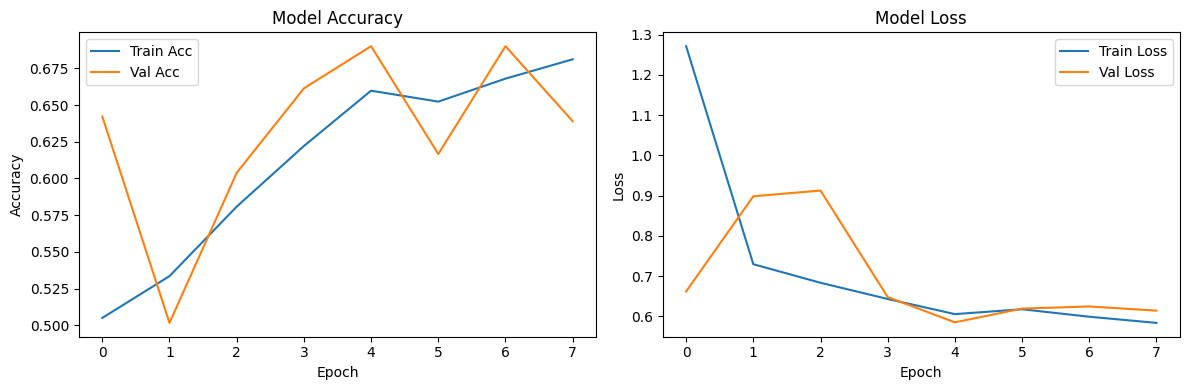

In [ ]:
#@title model ANN different
model_ann_different = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48, 64, 3)),
    tf.keras.layers.Dense(2048, activation='selu'),
    tf.keras.layers.AlphaDropout(0.3),
    tf.keras.layers.Dense(512, activation='selu'),
    tf.keras.layers.AlphaDropout(0.3),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_ann_different.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history=model_ann_different.fit(
    x_train, y_train,
    validation_data=(x_validate, y_validate),
    epochs=8,
    batch_size=32
)

test_loss_ann_different, test_acc_ann_different = model_ann_different.evaluate(x_test, y_test)
print('Test accuracy (ANN diferente):', test_acc_ann_different)

plot_model_history(history)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - accuracy: 0.6319 - loss: 0.6318 - val_accuracy: 0.6454 - val_loss: 0.6576
Epoch 2/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.6950 - loss: 0.5657 - val_accuracy: 0.6837 - val_loss: 0.5594
Epoch 3/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.7214 - loss: 0.5267 - val_accuracy: 0.6709 - val_loss: 0.5447
Epoch 4/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.7081 - loss: 0.5323 - val_accuracy: 0.6390 - val_loss: 0.6110
Epoch 5/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.7158 - loss: 0.5151 - val_accuracy: 0.6901 - val_loss: 0.5668
Epoch 6/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.7354 - loss: 0.4936 - val_accuracy: 0.7029 - val_loss: 0.5211
Epoch 7/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.7305 - loss: 0.4945 - val_accuracy: 0.6805 - val_loss: 0.5580
Epoch 8/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.7400 - loss: 0.4782 - val_accu

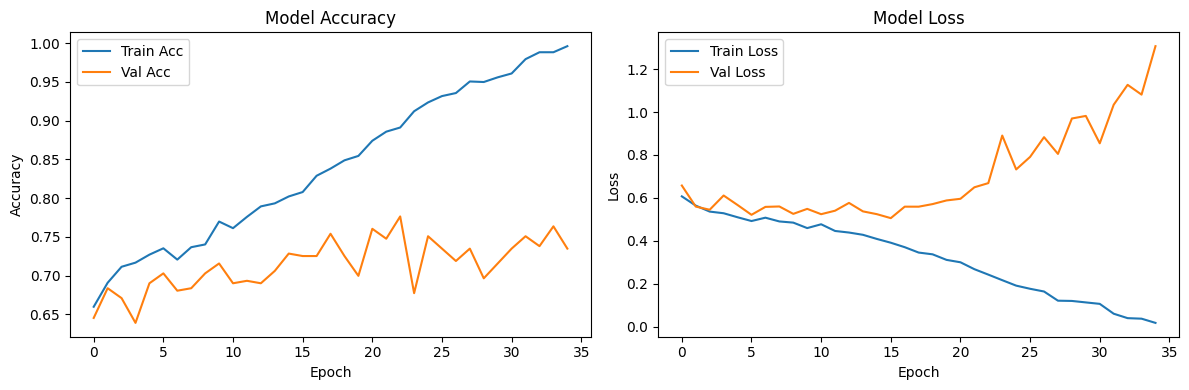

In [ ]:
#@title model CONV2D
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history=model_cnn.fit(
    x_train, y_train,
    validation_data=(x_validate, y_validate),
    epochs=35,
    batch_size=32
)

test_loss_cnn, test_acc_cnn = model_cnn.evaluate(x_test, y_test)
print('Test accuracy (CNN):', test_acc_cnn)

plot_model_history(history)

In [ ]:
X_flat = X.reshape(len(X), -1)
x_trainnn, x_testtt, y_trainnn, y_testtt = train_test_split(X_flat, y, stratify=y, test_size=0.2)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

x_train, x_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2)

svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)

print(classification_report(y_test, y_pred_svm))

[[231 159]
 [108 283]]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63       390
           1       0.64      0.72      0.68       391

    accuracy                           0.66       781
   macro avg       0.66      0.66      0.66       781
weighted avg       0.66      0.66      0.66       781



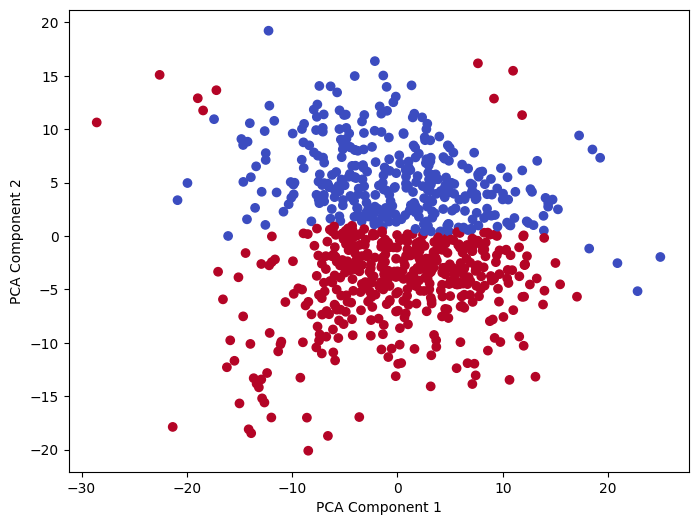

In [ ]:
import matplotlib.pyplot as plt

# Visualización de predicciones del SVM
plt.figure(figsize=(8,6))
plt.scatter(x_testtt[:, 0], x_testtt[:, 1], c=y_pred_svm, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


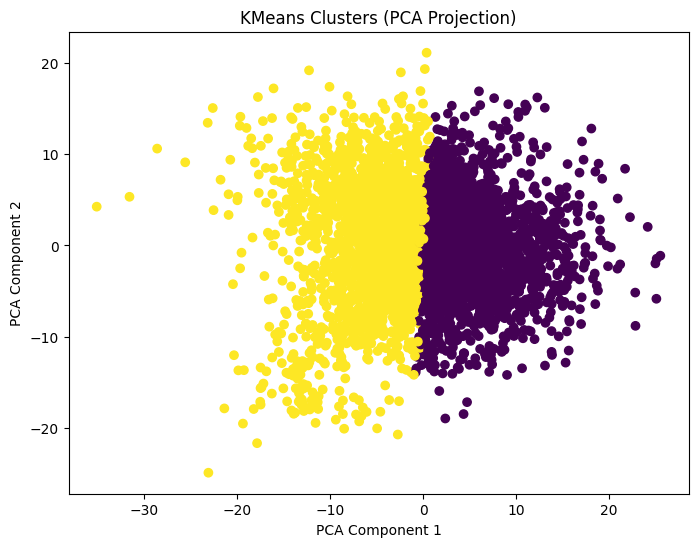

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis')
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


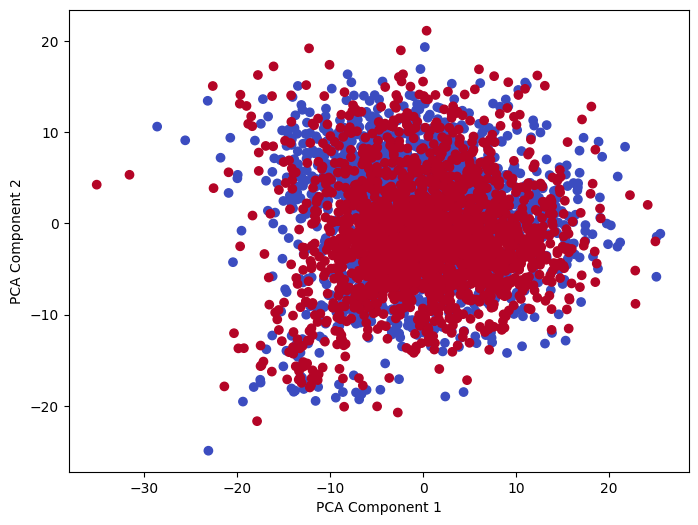

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=2, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_flat)

print(classification_report(y, clusters_kmeans))

[[ 949 1003]
 [1024  928]]
              precision    recall  f1-score   support

           0       0.48      0.49      0.48      1952
           1       0.48      0.48      0.48      1952

    accuracy                           0.48      3904
   macro avg       0.48      0.48      0.48      3904
weighted avg       0.48      0.48      0.48      3904



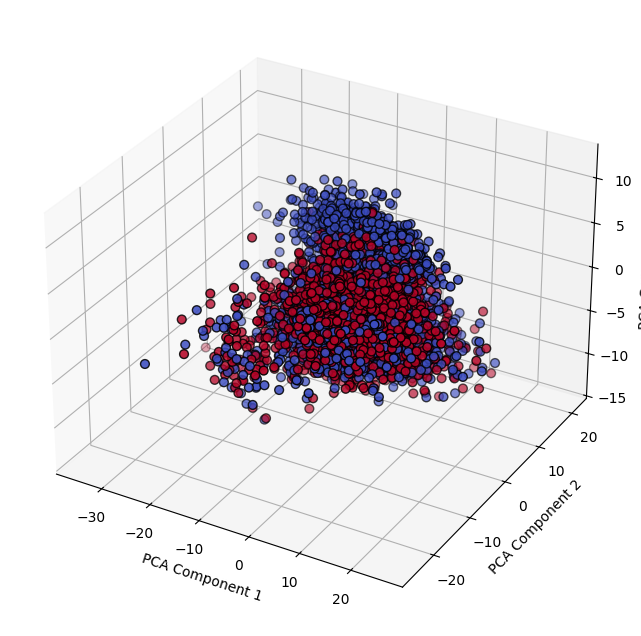

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # Import para 3D

# Reducción de dimensionalidad a 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_flat)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Visualizar con etiquetas verdaderas
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=y, cmap='coolwarm', edgecolors='k', s=40)

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

plt.show()


In [ ]:
y_pred_relu = model_ann_relu.predict(x_test)
y_pred_different = model_ann_different.predict(x_test)
y_pred_cnn = model_cnn.predict(x_test)
y_pred_relu = np.argmax(y_pred_relu, axis=1)
y_pred_different = np.argmax(y_pred_different, axis=1)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


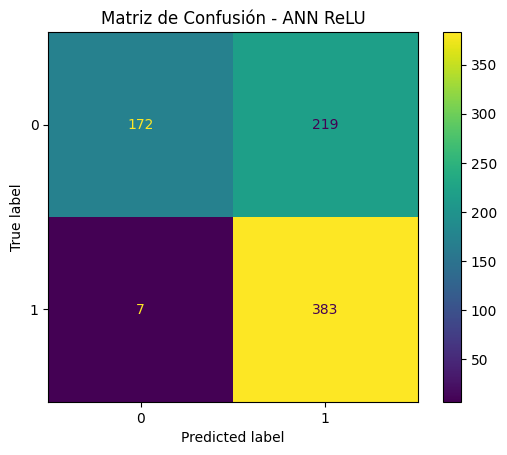

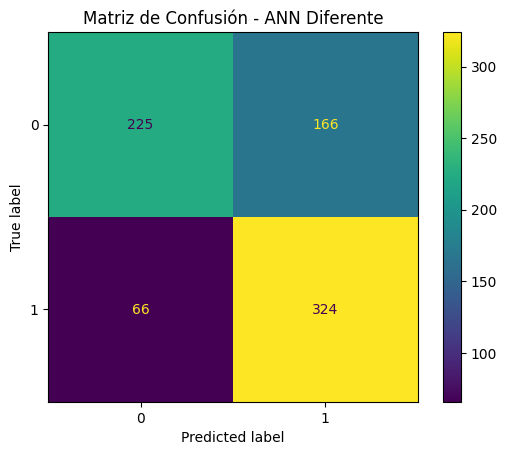

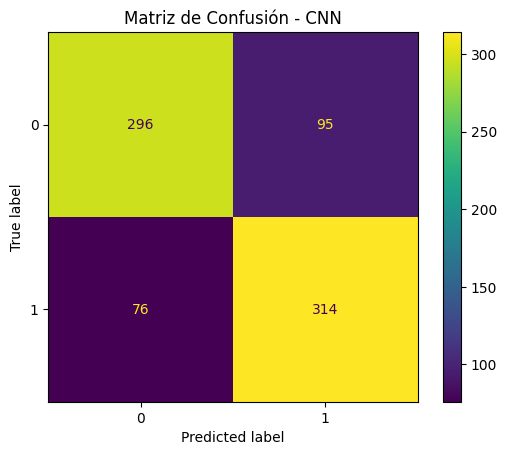

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

modelos = {
    "ANN ReLU": y_pred_relu,
    "ANN Diferente": y_pred_different,
    "CNN": y_pred_cnn
}

for nombre, pred in modelos.items():
    cm = confusion_matrix(y_test_classes, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

modelos = {
    "ANN ReLU": y_pred_relu,
    "ANN Diferente": y_pred_different,
    "CNN": y_pred_cnn
}

comparacion = {
    "Modelo": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": []
}

for nombre, pred in modelos.items():
    comparacion["Modelo"].append(f"{nombre}")
    comparacion["Accuracy"].append(accuracy_score(y_test_classes, pred))
    comparacion["Precision"].append(precision_score(y_test_classes, pred, average='macro', zero_division=0))
    comparacion["Recall"].append(recall_score(y_test_classes, pred, average='macro', zero_division=0))

df_comparacion = pd.DataFrame(comparacion)
print(df_comparacion)


          Modelo  Accuracy  Precision    Recall
0       ANN ReLU  0.710627   0.798553  0.710974
1  ANN Diferente  0.702945   0.717210  0.703108
2            CNN  0.781050   0.781713  0.781081


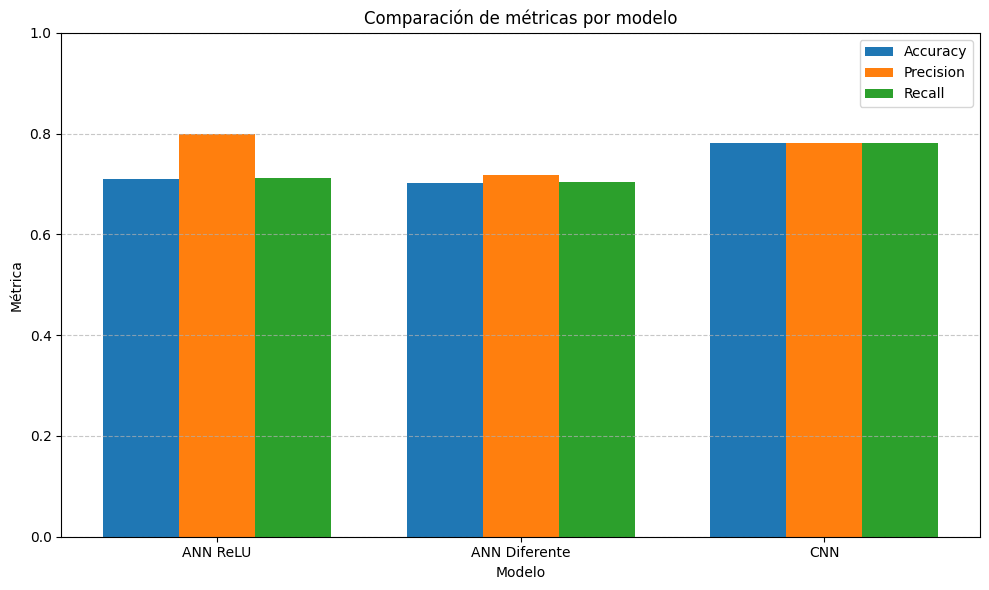

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = df_comparacion["Modelo"]
accuracy = df_comparacion["Accuracy"]
precision = df_comparacion["Precision"]
recall = df_comparacion["Recall"]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, precision, width, label='Precision')
plt.bar(x + width, recall, width, label='Recall')

plt.xlabel('Modelo')
plt.ylabel('Métrica')
plt.title('Comparación de métricas por modelo')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


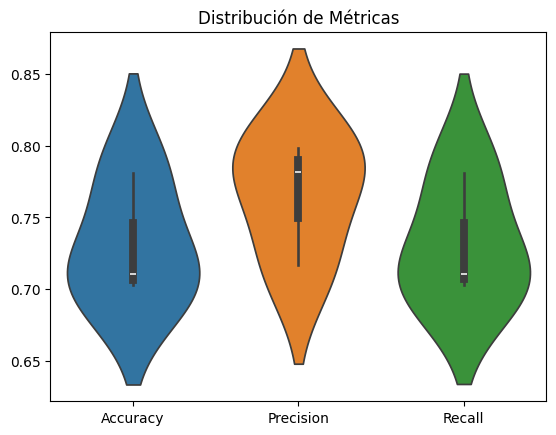

In [ ]:
sns.violinplot(data=[df_comparacion["Accuracy"], df_comparacion["Precision"], df_comparacion["Recall"]])
plt.xticks([0, 1, 2], ['Accuracy', 'Precision', 'Recall'])
plt.title("Distribución de Métricas")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test, axis=1)

y_pred_ann_relu = np.argmax(model_ann_relu.predict(x_test), axis=1)
y_pred_ann_other = np.argmax(model_ann_different.predict(x_test), axis=1)
y_pred_cnn = np.argmax(model_cnn.predict(x_test), axis=1)

report_ann_relu = classification_report(y_test_labels, y_pred_ann_relu, output_dict=True)
report_ann_other = classification_report(y_test_labels, y_pred_ann_other, output_dict=True)
report_cnn = classification_report(y_test_labels, y_pred_cnn, output_dict=True)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [ ]:
import pandas as pd

resumen = pd.DataFrame([
    {"Modelo": "ANN ReLU", "Accuracy": report_ann_relu["accuracy"], "Precision": report_ann_relu["weighted avg"]["precision"], "Recall": report_ann_relu["weighted avg"]["recall"], "F1": report_ann_relu["weighted avg"]["f1-score"]},
    {"Modelo": "ANN Otro", "Accuracy": report_ann_other["accuracy"], "Precision": report_ann_other["weighted avg"]["precision"], "Recall": report_ann_other["weighted avg"]["recall"], "F1": report_ann_other["weighted avg"]["f1-score"]},
    {"Modelo": "CNN", "Accuracy": report_cnn["accuracy"], "Precision": report_cnn["weighted avg"]["precision"], "Recall": report_cnn["weighted avg"]["recall"], "F1": report_cnn["weighted avg"]["f1-score"]},
])

print(resumen)


     Modelo  Accuracy  Precision    Recall        F1
0  ANN ReLU  0.710627   0.798761  0.710627  0.687735
1  ANN Otro  0.702945   0.717282  0.702945  0.698045
2       CNN  0.781050   0.781730  0.781050  0.780927


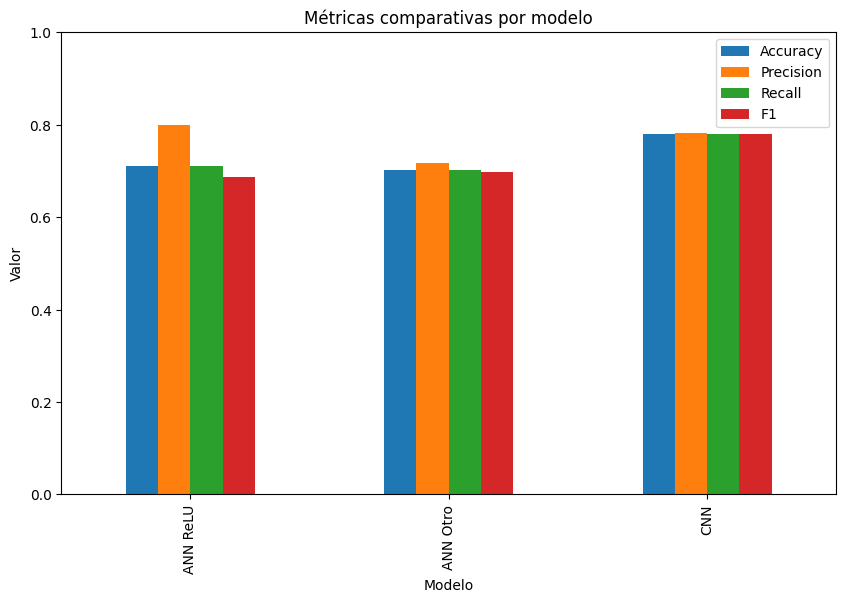

In [ ]:
resumen.plot(x="Modelo", kind="bar", figsize=(10,6), title="Métricas comparativas por modelo")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.show()


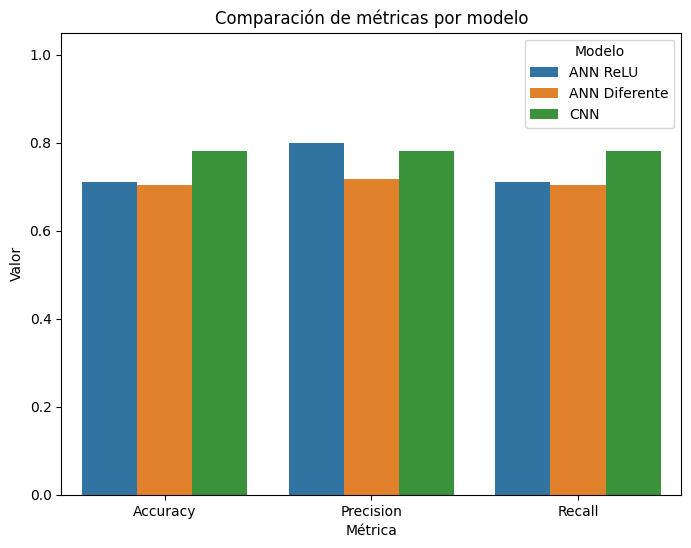

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_melted = df_comparacion.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")
plt.figure(figsize=(8,6))
sns.barplot(data=df_melted, x="Métrica", y="Valor", hue="Modelo")
plt.title("Comparación de métricas por modelo")
plt.ylim(0, 1.05)
plt.show()

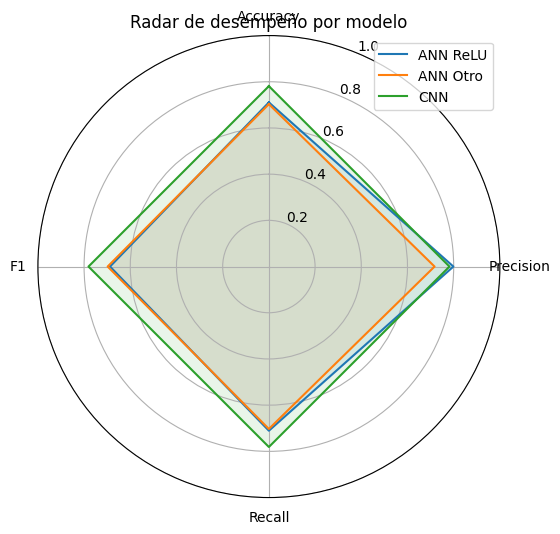

In [ ]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for i, row in resumen.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row["Modelo"])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
plt.title("Radar de desempeño por modelo")
plt.legend(loc='upper right')
plt.show()

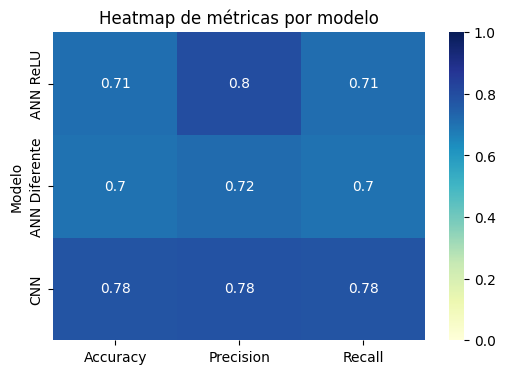

In [ ]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(df_comparacion.set_index("Modelo"), annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Heatmap de métricas por modelo")
plt.show()

In [ ]:
#@title Mejor Modelo
data = {
    'Modelo': resumen['Modelo'].tolist(),
    'Accuracy': resumen['Accuracy'].tolist(),
    'Precision': resumen['Precision'].tolist(),
    'Recall': resumen['Recall'].tolist(),
    'F1-Score': resumen['F1'].tolist()
}

df_results = pd.DataFrame(data)
print("Comparación de Modelos")
print(df_results)

weights = {
    'Accuracy': 0.2,
    'Precision': 0.2,
    'Recall': 0.3,
    'F1-Score': 0.3
}

df_results['Combined_Score'] = (
    df_results['Accuracy'] * weights['Accuracy'] +
    df_results['Precision'] * weights['Precision'] +
    df_results['Recall'] * weights['Recall'] +
    df_results['F1-Score'] * weights['F1-Score']
)

best_overall_model_idx = df_results['Combined_Score'].idxmax()
best_overall_model = df_results.loc[best_overall_model_idx]

print("\nModelos con Score Combinado")
print(df_results.sort_values(by='Combined_Score', ascending=False))

print(f"\nEl Mejor Modelo es:")
print(best_overall_model)

Comparación de Modelos
     Modelo  Accuracy  Precision    Recall  F1-Score
0  ANN ReLU  0.710627   0.798761  0.710627  0.687735
1  ANN Otro  0.702945   0.717282  0.702945  0.698045
2       CNN  0.781050   0.781730  0.781050  0.780927

Modelos con Score Combinado
     Modelo  Accuracy  Precision    Recall  F1-Score  Combined_Score
2       CNN  0.781050   0.781730  0.781050  0.780927        0.781149
0  ANN ReLU  0.710627   0.798761  0.710627  0.687735        0.721386
1  ANN Otro  0.702945   0.717282  0.702945  0.698045        0.704342

El Mejor Modelo es:
Modelo                 CNN
Accuracy           0.78105
Precision          0.78173
Recall             0.78105
F1-Score          0.780927
Combined_Score    0.781149
Name: 2, dtype: object


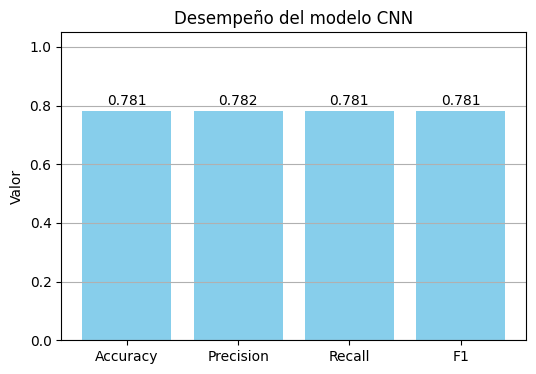

In [ ]:
mejor_modelo = resumen.loc[resumen["Accuracy"].idxmax()]

valores = mejor_modelo[['Accuracy', 'Precision', 'Recall', 'F1']].values

nombres = ["Accuracy", "Precision", "Recall", "F1"]

plt.figure(figsize=(6, 4))
bars = plt.bar(nombres, valores, color='skyblue')
plt.ylim(0, 1.05)
plt.title(f"Desempeño del modelo {mejor_modelo['Modelo']}")
plt.ylabel("Valor")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.grid(True, axis='y')
plt.show()

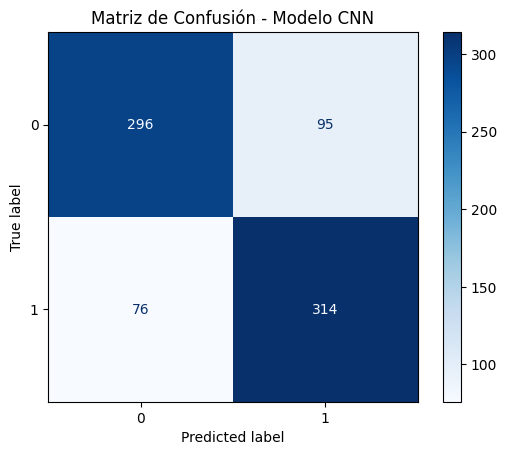

In [ ]:
y_true = y_test_classes
y_pred = y_pred_cnn

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Modelo CNN")
plt.show()

### Conclusión Final

De los modelos evaluados, el modelo basado en **Red Neuronal Convolucional (CNN)** obtuvo el mejor desempeño general.

Las métricas obtenidas por este modelo fueron:

- **Accuracy**: 0.78105   
- **Precision**: 0.78173
- **Recall**: 0.78105
- **F1-score**: 0.7809

Este rendimiento superior se debe a que la arquitectura CNN es especialmente adecuada para el procesamiento de imágenes, ya que puede captar patrones espaciales locales (como bordes, texturas y formas). Esto la hace más efectiva que modelos totalmente conectados (ANN) al trabajar con datos visuales, como los usados en este proyecto de clasificación de cáncer de piel.
